<a href="https://colab.research.google.com/github/NayePQ/LPDGAN/blob/main/Data_augmentation_deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install glog

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-gflags: filename=python_gflags-3.1.2-py3-none-any.whl size=57370 sha256=b64479eb8f3353baa828c22fc43b553ede79f0caf1ea21552e6a0c06bff6d0fe
  Stored in directory: /root/.cache/pip/wheels/08/32/87/be6254803d81af495c135b8b662d4a076e7a91dc7766f05a25
Successfully built python-gflags


In [2]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.3
    Uninstalling albumentations-2.0.3:
      Successfully uninstalled albumentations-2.0.3


In [3]:
!pip install dominate

In [14]:
import os
from glob import glob
from glog import logger
from torch.utils.data import Dataset
from data import aug
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import pandas as pd


class LPBlurDataset(Dataset):
    def __init__(self, opt):
        super(LPBlurDataset, self).__init__()
        self.opt = opt

        self.files_a = os.path.join(opt.dataroot, opt.mode, 'blur')
        self.files_b = os.path.join(opt.dataroot, opt.mode, 'sharp')

        self.blur = glob(os.path.join(self.files_a, '*.jpg'))
        self.sharp = glob(os.path.join(self.files_b, '*.jpg'))
        assert len(self.blur) == len(self.sharp)

        if self.opt.mode == 'train':
            df = pd.read_csv(os.path.join(opt.dataroot, 'plate_info.txt'), header=None,
                             names=['ImageName', 'PlateInfo'])
            self.txt = df.set_index('ImageName')['PlateInfo'].to_dict()
            self.transform_fn = aug.get_transforms(size=(112, 224))
            self.transform_fn1 = aug.get_transforms(size=(56, 112))
            self.transform_fn2 = aug.get_transforms(size=(28, 56))
            self.transform_fn3 = aug.get_transforms(size=(14, 28))

        else:
            self.transform_fn = aug.get_transforms_fortest(size=(112, 224))
            self.transform_fn1 = aug.get_transforms_fortest(size=(56, 112))
            self.transform_fn2 = aug.get_transforms_fortest(size=(28, 56))
            self.transform_fn3 = aug.get_transforms_fortest(size=(14, 28))

        self.normalize_fn = aug.get_normalize()
        logger.info(f'Dataset has been created with {len(self.blur)} samples')

    def __len__(self):
        return len(self.blur)

    def __getitem__(self, idx):
        blur_image = Image.open(self.blur[idx])
        sharp_image = Image.open(self.sharp[idx])
        blur_image = np.array(blur_image)
        sharp_image = np.array(sharp_image)

        blur_image, sharp_image = self.transform_fn(blur_image, sharp_image)
        blur_image1, sharp_image1 = self.transform_fn1(blur_image, sharp_image)
        blur_image2, sharp_image2 = self.transform_fn2(blur_image, sharp_image)
        blur_image3, sharp_image3 = self.transform_fn3(blur_image, sharp_image)

        blur_image, sharp_image = self.normalize_fn(blur_image, sharp_image)
        blur_image1, sharp_image1 = self.normalize_fn(blur_image1, sharp_image1)
        blur_image2, sharp_image2 = self.normalize_fn(blur_image2, sharp_image2)
        blur_image3, sharp_image3 = self.normalize_fn(blur_image3, sharp_image3)

        blur_image = transforms.ToTensor()(blur_image)
        sharp_image = transforms.ToTensor()(sharp_image)
        blur_image1 = transforms.ToTensor()(blur_image1)
        sharp_image1 = transforms.ToTensor()(sharp_image1)
        blur_image2 = transforms.ToTensor()(blur_image2)
        sharp_image2 = transforms.ToTensor()(sharp_image2)
        blur_image3 = transforms.ToTensor()(blur_image3)
        sharp_image3 = transforms.ToTensor()(sharp_image3)

        if self.opt.mode == 'train':
            plate_info = self.txt[os.path.basename(self.sharp[idx])]
            try:
                plate_info = np.fromstring(plate_info, sep=' ')

            except (SyntaxError, ValueError) as e:
                print(f"Error restoring array: {e}")

            plate_info = torch.from_numpy(plate_info)

            return {'A': blur_image, 'B': sharp_image, 'A_paths': self.blur[idx], 'B_paths': self.sharp[idx],
                    'A1': blur_image1, 'B1': sharp_image1, 'A2': blur_image2, 'B2': sharp_image2, 'A3': blur_image3,
                    'B3': sharp_image3, 'plate_info': plate_info}  # A: blur B: sharp

        else:
            return {'A': blur_image, 'B': sharp_image, 'A_paths': self.blur[idx], 'B_paths': self.sharp[idx],
                    'A1': blur_image1, 'B1': sharp_image1, 'A2': blur_image2, 'B2': sharp_image2, 'A3': blur_image3,
                    'B3': sharp_image3}

    def load_data(self):
        dataloader = torch.utils.data.DataLoader(
            self,
            batch_size=self.opt.batch_size,
            shuffle=True,
            num_workers=int(self.opt.num_threads))
        return dataloader


def create_dataset(opt):
    return LPBlurDataset(opt).load_data()

In [5]:
!pip install yacs

In [6]:
import torch
from models import networks
from models.networks import NLayerDiscriminator, PixelDiscriminator, SwinTransformer_Backbone
import functools
import sys
from collections import OrderedDict
import os
import torch.nn as nn
from models.config_su import get_config_or
sys.path.append("..")


class LPDGAN(nn.Module):
    def __init__(self, opt):
        super(LPDGAN, self).__init__()
        self.opt = opt
        self.mode = opt.mode
        self.gpu_ids = opt.gpu_ids
        self.save_dir = os.path.join(opt.checkpoints_dir, opt.name)
        self.loss_names = []
        self.model_names = []
        self.visual_names = []
        self.optimizers = []
        self.image_paths = []
        self.metric = 0
        self.device = torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')
        self.visual_names = ['real_A', 'fake_B', 'real_B']
        config_su = get_config_or()
        self.netG = SwinTransformer_Backbone(config_su).to(self.device)

        self.criterionL1 = torch.nn.L1Loss()
        self.perceptualLoss = networks.PerceptualLoss().to(self.device)

        if self.mode == 'train':
            self.model_names = ['G', 'D', 'D_smallblock', 'D1', 'D2']
            self.netD = NLayerDiscriminator(opt.input_nc + opt.output_nc, opt.ndf, n_layers=3, norm_layer=functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)).to(self.device)
            self.netD1 = NLayerDiscriminator(opt.input_nc + opt.output_nc, opt.ndf, n_layers=3, norm_layer=functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)).to(self.device)
            self.netD2 = NLayerDiscriminator(opt.input_nc + opt.output_nc, opt.ndf, n_layers=3, norm_layer=functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)).to(self.device)

            self.netD_smallblock = PixelDiscriminator(opt.input_nc, opt.ndf, norm_layer=functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)).to(self.device)

            self.loss_names = ['G_GAN', 'G_L1', 'PlateNum_L1', 'D_GAN', 'P_loss', 'D_real', 'D_fake', 'D_s']
            self.criterionGAN = networks.GANLoss(opt.gan_mode).to(self.device)
            self.criterionGAN_s = networks.GANLoss('lsgan').to(self.device)

            self.optimizer_G = torch.optim.Adam(self.netG.parameters(), lr=opt.lr, betas=(0.5, 0.999))
            self.optimizer_D = torch.optim.Adam(self.netD.parameters(), lr=opt.lr, betas=(0.5, 0.999))
            self.optimizer_D_smallblock = torch.optim.Adam(self.netD_smallblock.parameters(), lr=opt.lr,
                                                           betas=(0.5, 0.999))

            self.optimizers.append(self.optimizer_G)
            self.optimizers.append(self.optimizer_D)
            self.optimizers.append(self.optimizer_D_smallblock)
            self.schedulers = [networks.get_scheduler(optimizer, opt) for optimizer in self.optimizers]

        else:

            self.model_names = ['G']
            self.loss_names = []


    def setup(self, opt):
        if self.mode == 'train':
            self.schedulers = [networks.get_scheduler(optimizer, opt) for optimizer in self.optimizers]
        if self.mode != 'train' or opt.continue_train:
            load_suffix = opt.load_iter if opt.load_iter > 0 else opt.epoch
            self.load_networks(load_suffix)

    def set_input(self, input):
        self.real_A = input['A'].to(self.device)
        self.real_B = input['B'].to(self.device)
        self.real_A1 = input['A1'].to(self.device)
        self.real_B1 = input['B1'].to(self.device)
        self.real_A2 = input['A2'].to(self.device)
        self.real_B2 = input['B2'].to(self.device)
        self.real_A3 = input['A3'].to(self.device)
        self.real_B3 = input['B3'].to(self.device)
        self.image_paths = input['A_paths']

        if self.mode == 'train':
            self.plate_info = input['plate_info'].to(self.device)

    def forward(self):
        self.fake_B, self.fake_B1, self.fake_B2, self.fake_B3, self.plate1, self.plate2 = self.netG(self.real_A,
                                                                                                    self.real_A1,
                                                                                                    self.real_A2,
                                                                                                    self.real_A3)
        self.fake_B_split = torch.chunk(self.fake_B, 7, dim=3)
        self.real_B_split = torch.chunk(self.real_B, 7, dim=3)
        self.real_A_split = torch.chunk(self.real_A, 7, dim=3)

    def set_requires_grad(self, nets, requires_grad=False):
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

    def test(self):
        with torch.no_grad():
            self.forward()

    def cal_small_D(self):
        loss_D_s_fake = 0
        loss_D_s_real = 0
        for i in range(len(self.fake_B_split)):
            pred_s_fake = self.netD_smallblock(self.fake_B_split[i].detach())
            loss_D_s_fake_tmp = self.criterionGAN_s(pred_s_fake, False)

            pred_s_real = self.netD_smallblock(self.real_B_split[i].detach())
            loss_D_s_real_tmp = self.criterionGAN_s(pred_s_real, True)

            loss_D_s_fake += loss_D_s_fake_tmp
            loss_D_s_real += loss_D_s_real_tmp

        return loss_D_s_fake / 7.0, loss_D_s_real / 7.0

    def cal_small_G(self):
        loss_G_s_fake = 0
        for i in range(len(self.fake_B_split)):
            pred_s_fake = self.netD_smallblock(self.fake_B_split[i].detach())
            loss_G_s_fake_tmp = self.criterionGAN_s(pred_s_fake, True)

            loss_G_s_fake += loss_G_s_fake_tmp

        return loss_G_s_fake / 7.0

    def backward_D(self):
        fake_AB = torch.cat((self.real_A, self.fake_B),
                            1)
        pred_fake = self.netD(fake_AB.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)

        real_AB = torch.cat((self.real_A, self.real_B), 1)
        pred_real = self.netD(real_AB)
        loss_D_real = self.criterionGAN(pred_real, True)

        fake_AB1 = torch.cat((self.real_A1, self.fake_B1),
                             1)
        pred_fake1 = self.netD1(fake_AB1.detach())
        loss_D_fake1 = self.criterionGAN(pred_fake1, False)

        real_AB1 = torch.cat((self.real_A1, self.real_B1), 1)
        pred_real1 = self.netD1(real_AB1)
        loss_D_real1 = self.criterionGAN(pred_real1, True)

        fake_AB2 = torch.cat((self.real_A2, self.fake_B2),
                             1)
        pred_fake2 = self.netD2(fake_AB2.detach())
        loss_D_fake2 = self.criterionGAN(pred_fake2, False)

        real_AB2 = torch.cat((self.real_A2, self.real_B2), 1)
        pred_real2 = self.netD2(real_AB2)
        loss_D_real2 = self.criterionGAN(pred_real2, True)

        self.loss_D_fake = (loss_D_fake + loss_D_fake1 + loss_D_fake2) / 3
        self.loss_D_real = (loss_D_real + loss_D_real1 + loss_D_real2) / 3

        self.loss_D_GAN = (loss_D_fake + loss_D_real + loss_D_fake1 + loss_D_real1 +
                           loss_D_fake2 + loss_D_real2) * 0.5 / 3

        loss_D_s_fake, loss_D_s_real = self.cal_small_D()
        self.loss_D_s = (loss_D_s_fake + loss_D_s_real) * 0.5

        self.loss_D_gp = (self.cal_gp(fake_AB, real_AB) + self.cal_gp(fake_AB1, real_AB1) +
                          self.cal_gp(fake_AB2, real_AB2)) * 10 / 3

        self.loss_D = self.loss_D_GAN + self.loss_D_gp + self.loss_D_s
        self.loss_D.backward(retain_graph=True)

    def backward_G(self):
        fake_AB = torch.cat((self.real_A, self.fake_B), 1)
        pred_fake = self.netD(fake_AB)
        loss_G_GAN = self.criterionGAN(pred_fake, True)

        fake_AB1 = torch.cat((self.real_A1, self.fake_B1), 1)
        pred_fake1 = self.netD1(fake_AB1)
        loss_G_GAN1 = self.criterionGAN(pred_fake1, True)

        fake_AB2 = torch.cat((self.real_A2, self.fake_B2), 1)
        pred_fake2 = self.netD2(fake_AB2)
        loss_G_GAN2 = self.criterionGAN(pred_fake2, True)

        self.loss_G_GAN = (loss_G_GAN + loss_G_GAN1 + loss_G_GAN2) / 3

        self.loss_G_s = self.cal_small_G()

        loss_G_L1 = self.criterionL1(self.fake_B, self.real_B) * self.opt.lambda_L1
        loss_G_L11 = self.criterionL1(self.fake_B1, self.real_B1) * self.opt.lambda_L1
        loss_G_L12 = self.criterionL1(self.fake_B2, self.real_B2) * self.opt.lambda_L1
        loss_G_L13 = self.criterionL1(self.fake_B3, self.real_B3) * self.opt.lambda_L1

        self.loss_G_L1 = (loss_G_L1 + loss_G_L11 + loss_G_L12 + loss_G_L13) / 4 * 0.01

        loss_P_loss = self.perceptualLoss(self.fake_B, self.real_B)
        loss_P_loss1 = self.perceptualLoss(self.fake_B1, self.real_B1)
        loss_P_loss2 = self.perceptualLoss(self.fake_B2, self.real_B2)
        loss_P_loss3 = self.perceptualLoss(self.fake_B3, self.real_B3)

        self.loss_P_loss = (loss_P_loss + loss_P_loss1 + loss_P_loss2 + loss_P_loss3) / 4 * 0.01

        self.loss_PlateNum_L1 = (self.criterionL1(self.plate1, self.plate_info) + self.criterionL1(self.plate2,
                                                                                                   self.plate_info)) / 2 * 0.01

        self.loss_G = self.loss_G_GAN + self.loss_G_s + self.loss_G_L1 + self.loss_P_loss + 0.1 * self.loss_PlateNum_L1
        self.loss_G.backward()

    def optimize_parameters(self):
        self.forward()
        self.set_requires_grad(self.netD, True)
        self.optimizer_D.zero_grad()
        self.backward_D()
        self.optimizer_D.step()

        self.set_requires_grad(self.netD, False)
        self.optimizer_G.zero_grad()
        self.backward_G()
        self.optimizer_G.step()

    def cal_gp(self, fake_AB, real_AB):
        r = torch.rand(size=(real_AB.shape[0], 1, 1, 1))
        r = r.cuda()
        x = (r * real_AB + (1 - r) * fake_AB).requires_grad_(True)
        d = self.netD(x)
        fake = torch.ones_like(d)
        fake = fake.cuda()
        g = torch.autograd.grad(
            outputs=d,
            inputs=x,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True
        )[0]
        gp = ((g.norm(2, dim=1) - 1) ** 2).mean()
        return gp


    def get_image_paths(self):
        return self.image_paths

    def update_learning_rate(self):
        old_lr = self.optimizers[0].param_groups[0]['lr']
        for scheduler in self.schedulers:
            if self.opt.lr_policy == 'plateau':
                scheduler.step(self.metric)
            else:
                scheduler.step()

        lr = self.optimizers[0].param_groups[0]['lr']
        print('learning rate %.7f -> %.7f' % (old_lr, lr))

    def get_current_visuals(self):
        visual_ret = OrderedDict()
        for name in self.visual_names:
            if isinstance(name, str):
                visual_ret[name] = getattr(self, name)
        return visual_ret

    def get_current_losses(self):
        errors_ret = OrderedDict()
        for name in self.loss_names:
            if isinstance(name, str):
                errors_ret[name] = float(
                    getattr(self, 'loss_' + name))
        return errors_ret

    def save_networks(self, epoch):
        for name in self.model_names:
            if isinstance(name, str):
                save_filename = '%s_net_%s.pth' % (epoch, name)
                save_path = os.path.join(self.save_dir, save_filename)
                net = getattr(self, 'net' + name)

                torch.save(net.cpu().state_dict(), save_path)
                net.to(self.device)


    def load_networks(self, epoch):
        for name in self.model_names:
            if isinstance(name, str):
                load_filename = '%s_net_%s.pth' % (epoch, name)
                load_path = os.path.join(self.save_dir, load_filename)
                net = getattr(self, 'net' + name)
                if isinstance(net, torch.nn.DataParallel):
                    net = net.module
                print('loading the model from %s' % load_path)
                state_dict = torch.load(load_path, map_location=str(self.device))
                if hasattr(state_dict, '_metadata'):
                    del state_dict._metadata
                net.load_state_dict(state_dict)

def create_model(opt):
    return LPDGAN(opt=opt)



  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)

W0212 23:25:24.347047 1028 warnings.py:110] /usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)



In [7]:
!pip install dominate

In [8]:
import numpy as np
import os
import ntpath
import time
from util import util, html

def save_images(webpage, visuals, image_path, aspect_ratio=1.0, width=256):
    """Save images to the disk.

    Parameters:
        webpage (the HTML class) -- the HTML webpage class that stores these imaegs (see html.py for more details)
        visuals (OrderedDict)    -- an ordered dictionary that stores (name, images (either tensor or numpy) ) pairs
        image_path (str)         -- the string is used to create image paths
        aspect_ratio (float)     -- the aspect ratio of saved images
        width (int)              -- the images will be resized to width x width

    This function will save images stored in 'visuals' to the HTML file specified by 'webpage'.
    """
    image_dir = webpage.get_image_dir()
    short_path = ntpath.basename(image_path[0])
    name = os.path.splitext(short_path)[0]

    webpage.add_header(name)
    ims, txts, links = [], [], []
    for label, im_data in visuals.items():
        im = util.tensor2im(im_data)
        image_name = '%s_%s.png' % (name, label)
        save_path = os.path.join(image_dir, image_name)
        util.save_image(im, save_path, aspect_ratio=aspect_ratio)
        ims.append(image_name)
        txts.append(label)
        links.append(image_name)
    webpage.add_images(ims, txts, links, width=width)



class Visualizer():
    """This class includes several functions that can display/save images and print/save logging information.

    It uses a Python library 'visdom' for display, and a Python library 'dominate' (wrapped in 'HTML') for creating HTML files with images.
    """

    def __init__(self, opt):
        """Initialize the Visualizer class"""

        self.opt = opt  # cache the option
        self.display_id = opt.display_id
        if opt.mode == 'train':
            isTrain = True
        else:
            isTrain = False

        self.use_html = isTrain and not opt.no_html

        self.win_size = opt.display_winsize
        self.name = opt.name
        self.saved = False
        self.current_epoch = 0
        self.ncols = opt.display_ncols

        if self.use_html:  # create an HTML object at <checkpoints_dir>/web/; images will be saved under <checkpoints_dir>/web/images/
            self.web_dir = os.path.join(opt.checkpoints_dir, opt.name, 'web')
            self.img_dir = os.path.join(self.web_dir, 'images')
            print('create web directory %s...' % self.web_dir)
            util.mkdirs([self.web_dir, self.img_dir])
        # create a logging file to store training losses
        self.log_name = os.path.join(opt.checkpoints_dir, opt.name, 'loss_log.txt')
        with open(self.log_name, "a") as log_file:
            now = time.strftime("%c")
            log_file.write('================ Training Loss (%s) ================\n' % now)

    def reset(self):
        """Reset the self.saved status"""
        self.saved = False


    def display_current_results(self, visuals, epoch, save_result):
        """ Save current results to an HTML file.

        Parameters:
            visuals (OrderedDict) - - dictionary of images to display or save
            epoch (int) - - the current epoch
            save_result (bool) - - if save the current results to an HTML file
        """
        if self.display_id > 0:  # show images in the browser using visdom
            ncols = self.ncols
            if ncols > 0:        # show all the images in one visdom panel
                ncols = min(ncols, len(visuals))
                label_html = ''
                label_html_row = ''
                images = []
                idx = 0
                for label, image in visuals.items():
                    image_numpy = util.tensor2im(image)
                    label_html_row += '<td>%s</td>' % label
                    images.append(image_numpy.transpose([2, 0, 1]))
                    idx += 1
                    if idx % ncols == 0:
                        label_html += '<tr>%s</tr>' % label_html_row
                        label_html_row = ''
                white_image = np.ones_like(image_numpy.transpose([2, 0, 1])) * 255
                while idx % ncols != 0:
                    images.append(white_image)
                    label_html_row += '<td></td>'
                    idx += 1
                if label_html_row != '':
                    label_html += '<tr>%s</tr>' % label_html_row

        if self.use_html and (save_result or not self.saved):  # save images to an HTML file if they haven't been saved.
            self.saved = True
            # save images to the disk
            for label, image in visuals.items():
                image_numpy = util.tensor2im(image)
                img_path = os.path.join(self.img_dir, 'epoch%.3d_%s.png' % (epoch, label))
                util.save_image(image_numpy, img_path)

            # update website
            webpage = html.HTML(self.web_dir, 'Experiment name = %s' % self.name, refresh=1)
            for n in range(epoch, 0, -1):
                webpage.add_header('epoch [%d]' % n)
                ims, txts, links = [], [], []

                for label, image_numpy in visuals.items():
                    image_numpy = util.tensor2im(image)
                    img_path = 'epoch%.3d_%s.png' % (n, label)
                    ims.append(img_path)
                    txts.append(label)
                    links.append(img_path)
                webpage.add_images(ims, txts, links, width=self.win_size)
            webpage.save()

    # losses: same format as |losses| of plot_current_losses
    def print_current_losses(self, epoch, iters, losses, t_comp, t_data):
        """print current losses on console; also save the losses to the disk

        Parameters:
            epoch (int) -- current epoch
            iters (int) -- current training iteration during this epoch (reset to 0 at the end of every epoch)
            losses (OrderedDict) -- training losses stored in the format of (name, float) pairs
            t_comp (float) -- computational time per data point (normalized by batch_size)
            t_data (float) -- data loading time per data point (normalized by batch_size)
        """
        message = '(epoch: %d, iters: %d, time: %.3f, data: %.3f) ' % (epoch, iters, t_comp, t_data)
        for k, v in losses.items():
            message += '%s: %.6f ' % (k, v)

        print(message)  # print the message
        with open(self.log_name, "a") as log_file:
            log_file.write('%s\n' % message)  # save the message




In [10]:
import time
from data.LPBlur_dataset import create_dataset
from models.LPDGAN import create_model
from util.visualizer import Visualizer
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

def trainer(opt):
    dataset = create_dataset(opt)
    dataset_size = len(dataset)
    print('The number of training images = %d' % dataset_size)

    model = create_model(opt)
    model.setup(opt)
    visualizer = Visualizer(opt)
    total_iters = 0

    for epoch in range(1, opt.n_epochs + opt.n_epochs_decay + 1):
        epoch_start_time = time.time()
        iter_data_time = time.time()
        epoch_iter = 0
        visualizer.reset()
        model.update_learning_rate()
        for i, data in enumerate(dataset):
            iter_start_time = time.time()
            if total_iters % opt.print_freq == 0:
                t_data = iter_start_time - iter_data_time

            total_iters += opt.batch_size
            epoch_iter += opt.batch_size
            model.set_input(data)
            model.optimize_parameters()

            if total_iters % opt.display_freq == 0:
                save_result = total_iters % opt.update_html_freq == 0
                visualizer.display_current_results(model.get_current_visuals(), epoch, save_result)

            if total_iters % opt.print_freq == 0:
                losses = model.get_current_losses()
                t_comp = (time.time() - iter_start_time) / opt.batch_size
                visualizer.print_current_losses(epoch, epoch_iter, losses, t_comp, t_data)

            if total_iters % opt.save_latest_freq == 0:
                print('saving the latest model (epoch %d, total_iters %d)' % (epoch, total_iters))
                save_suffix = 'iter_%d' % total_iters if opt.save_by_iter else 'latest'
                model.save_networks(save_suffix)

            iter_data_time = time.time()
        if epoch % opt.save_epoch_freq == 0:
            print('saving the model at the end of epoch %d, iters %d' % (epoch, total_iters))
            model.save_networks('latest')
            model.save_networks(epoch)

        print('End of epoch %d / %d \t Time Taken: %d sec' % (epoch, opt.n_epochs + opt.n_epochs_decay, time.time() - epoch_start_time))


In [11]:
import os
from data.LPBlur_dataset import create_dataset
from models.LPDGAN import create_model
from util.visualizer import save_images
from util import html


def print_test_losses(losses, results_dir, name):
    message = ''
    for k, v in losses.items():
        message += '%s: %.6f ' % (k, v)

    print(message)
    with open(os.path.join(results_dir, name, 'loss_log.txt'), "a") as log_file:
        log_file.write('%s\n' % message)

def test(opt):
    opt.num_threads = 0
    opt.batch_size = 1
    opt.serial_batches = True
    opt.no_flip = True
    opt.display_id = -1
    dataset = create_dataset(opt)
    model = create_model(opt)
    model.setup(opt)

    web_dir = os.path.join(opt.results_dir, opt.name, '{}_{}'.format(opt.mode, opt.epoch))
    if opt.load_iter > 0:
        web_dir = '{:s}_iter{:d}'.format(web_dir, opt.load_iter)
    print('creating web directory', web_dir)
    webpage = html.HTML(web_dir, 'Experiment = %s, Phase = %s, Epoch = %s' % (opt.name, opt.mode, opt.epoch))

    for i, data in enumerate(dataset):
        if i >= opt.num_test:
            break
        model.set_input(data)
        model.test()
        losses = model.get_current_losses()
        print_test_losses(losses, opt.results_dir, opt.name)
        visuals = model.get_current_visuals()
        img_path = model.get_image_paths()
        if i % 5 == 0:
            print('processing (%04d)-th image... %s' % (i, img_path))
        save_images(webpage, visuals, img_path, aspect_ratio=opt.aspect_ratio, width=opt.display_winsize)
    webpage.save()


In [15]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import argparse
from train import trainer
from test import test

def main(opt):
    if not os.path.exists(opt.checkpoints_dir):
        os.makedirs(opt.checkpoints_dir)
    if not os.path.exists(opt.results_dir):
        os.makedirs(opt.results_dir)

    if opt.mode == 'train':
        trainer(opt)

    elif opt.mode == 'test':
        test(opt)



if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    parser.add_argument('--name', default='LPDGAN', type=str)
    parser.add_argument('--dataroot', type=str, default=r'')
    parser.add_argument('--mode', default='train', choices=['train', 'test'], type=str)
    parser.add_argument('--gpu_ids', type=str, default='0')
    parser.add_argument('--checkpoints_dir', type=str, default='./checkpoints')
    parser.add_argument('--input_nc', type=int, default=3)
    parser.add_argument('--output_nc', type=int, default=3)
    parser.add_argument('--ndf', type=int, default=64)

    # Train
    parser.add_argument('--batch_size', type=int, default=5)
    parser.add_argument('--weight_decay', type=float, default=0)
    parser.add_argument('--load_iter', type=int, default=200)
    parser.add_argument('--epoch', type=int, default=200)
    parser.add_argument('--print_freq', type=int, default=10400)
    parser.add_argument('--num_worker', type=int, default=0)
    parser.add_argument('--save_latest_freq', type=int, default=5000)
    parser.add_argument('--save_epoch_freq', type=int, default=5)
    parser.add_argument('--save_by_iter', action='store_true')
    parser.add_argument('--continue_train', action='store_true')
    parser.add_argument('--n_epochs', type=int, default=100, help='number of epochs with the initial learning rate')
    parser.add_argument('--n_epochs_decay', type=int, default=100,
                        help='number of epochs to linearly decay learning rate to zero')
    parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate for adam')
    parser.add_argument('--lr_policy', type=str, default='linear',
                        help='learning rate policy. [linear | step | plateau | cosine]')
    parser.add_argument('--lr_decay_iters', type=int, default=50,
                        help='multiply by a gamma every lr_decay_iters iterations')
    parser.add_argument('--gan_mode', type=str, default='wgangp')
    parser.add_argument('--num_threads', default=0, type=int, help='# threads for loading data')
    parser.add_argument('--lambda_L1', type=float, default=100.0, help='weight for L1 loss')
    # Test
    parser.add_argument('--results_dir', type=str, default='./results/', help='saves results here.')
    parser.add_argument('--aspect_ratio', type=float, default=1.0, help='aspect ratio of result images')
    parser.add_argument('--num_test', type=int, default=1000, help='how many test images to run')

    # For display
    parser.add_argument('--display_freq', type=int, default=10400, help='frequency of showing training results on screen')
    parser.add_argument('--display_ncols', type=int, default=3,
                        help='if positive, display all images in a single visdom web panel with certain number of images per row.')
    parser.add_argument('--display_id', type=int, default=1, help='window id of the web display')
    parser.add_argument('--update_html_freq', type=int, default=1000,
                        help='frequency of saving training results to html')
    parser.add_argument('--no_html', action='store_true',
                        help='do not save intermediate training results to [opt.checkpoints_dir]/[opt.name]/web/')
    parser.add_argument('--display_winsize', type=int, default=256, help='display window size for both visdom and HTML')

    args = parser.parse_args()
    print(args)
    main(args)




usage: colab_kernel_launcher.py [-h] [--name NAME] [--dataroot DATAROOT] [--mode {train,test}]
                                [--gpu_ids GPU_IDS] [--checkpoints_dir CHECKPOINTS_DIR]
                                [--input_nc INPUT_NC] [--output_nc OUTPUT_NC] [--ndf NDF]
                                [--batch_size BATCH_SIZE] [--weight_decay WEIGHT_DECAY]
                                [--load_iter LOAD_ITER] [--epoch EPOCH] [--print_freq PRINT_FREQ]
                                [--num_worker NUM_WORKER] [--save_latest_freq SAVE_LATEST_FREQ]
                                [--save_epoch_freq SAVE_EPOCH_FREQ] [--save_by_iter]
                                [--continue_train] [--n_epochs N_EPOCHS]
                                [--n_epochs_decay N_EPOCHS_DECAY] [--lr LR]
                                [--lr_policy LR_POLICY] [--lr_decay_iters LR_DECAY_ITERS]
                                [--gan_mode GAN_MODE] [--num_threads NUM_THREADS]
                                [--lamb

SystemExit: 2

  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)

W0213 00:01:47.184925 1028 warnings.py:110] /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)



In [20]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import argparse
from train import trainer
from test import test

def main(opt):
    if not os.path.exists(opt.checkpoints_dir):
        os.makedirs(opt.checkpoints_dir)
    if not os.path.exists(opt.results_dir):
        os.makedirs(opt.results_dir)

    if opt.mode == 'train':
        trainer(opt)

    elif opt.mode == 'test':
        test(opt)



if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    parser.add_argument('--name', default='LPDGAN', type=str)
    parser.add_argument('--dataroot', type=str, default=r'')
    parser.add_argument('--mode', default='train', choices=['train', 'test'], type=str)
    parser.add_argument('--gpu_ids', type=str, default='0')
    parser.add_argument('--checkpoints_dir', type=str, default='./checkpoints')
    parser.add_argument('--input_nc', type=int, default=3)
    parser.add_argument('--output_nc', type=int, default=3)
    parser.add_argument('--ndf', type=int, default=64)

    # Train
    parser.add_argument('--batch_size', type=int, default=5)
    parser.add_argument('--weight_decay', type=float, default=0)
    parser.add_argument('--load_iter', type=int, default=200)
    parser.add_argument('--epoch', type=int, default=200)
    parser.add_argument('--print_freq', type=int, default=10400)
    parser.add_argument('--num_worker', type=int, default=0)
    parser.add_argument('--save_latest_freq', type=int, default=5000)
    parser.add_argument('--save_epoch_freq', type=int, default=5)
    parser.add_argument('--save_by_iter', action='store_true')
    parser.add_argument('--continue_train', action='store_true')
    parser.add_argument('--n_epochs', type=int, default=100, help='number of epochs with the initial learning rate')
    parser.add_argument('--n_epochs_decay', type=int, default=100,
                        help='number of epochs to linearly decay learning rate to zero')
    parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate for adam')
    parser.add_argument('--lr_policy', type=str, default='linear',
                        help='learning rate policy. [linear | step | plateau | cosine]')
    parser.add_argument('--lr_decay_iters', type=int, default=50,
                        help='multiply by a gamma every lr_decay_iters iterations')
    parser.add_argument('--gan_mode', type=str, default='wgangp')
    parser.add_argument('--num_threads', default=0, type=int, help='# threads for loading data')
    parser.add_argument('--lambda_L1', type=float, default=100.0, help='weight for L1 loss')
    # Test
    parser.add_argument('--results_dir', type=str, default='./results/', help='saves results here.')
    parser.add_argument('--aspect_ratio', type=float, default=1.0, help='aspect ratio of result images')
    parser.add_argument('--num_test', type=int, default=1000, help='how many test images to run')

    # For display
    parser.add_argument('--display_freq', type=int, default=10400, help='frequency of showing training results on screen')
    parser.add_argument('--display_ncols', type=int, default=3,
                        help='if positive, display all images in a single visdom web panel with certain number of images per row.')
    parser.add_argument('--display_id', type=int, default=1, help='window id of the web display')
    parser.add_argument('--update_html_freq', type=int, default=1000,
                        help='frequency of saving training results to html')
    parser.add_argument('--no_html', action='store_true',
                        help='do not save intermediate training results to [opt.checkpoints_dir]/[opt.name]/web/')
    parser.add_argument('--display_winsize', type=int, default=256, help='display window size for both visdom and HTML')

    # The change is here. Instead of calling parse_args() directly, we
    # manually construct a list of arguments and pass it to parse_args().
    # This simulates how arguments would be passed in from the command line.

    # Example arguments: Replace with your desired values
    args_list = ['--dataroot', '/dataset', '--mode', 'train']
    args = parser.parse_args(args_list)

    print(args)
    main(args)

Namespace(name='LPDGAN', dataroot='/dataset', mode='train', gpu_ids='0', checkpoints_dir='./checkpoints', input_nc=3, output_nc=3, ndf=64, batch_size=5, weight_decay=0, load_iter=200, epoch=200, print_freq=10400, num_worker=0, save_latest_freq=5000, save_epoch_freq=5, save_by_iter=False, continue_train=False, n_epochs=100, n_epochs_decay=100, lr=0.0002, lr_policy='linear', lr_decay_iters=50, gan_mode='wgangp', num_threads=0, lambda_L1=100.0, results_dir='./results/', aspect_ratio=1.0, num_test=1000, display_freq=10400, display_ncols=3, display_id=1, update_html_freq=1000, no_html=False, display_winsize=256)


FileNotFoundError: [Errno 2] No such file or directory: '/dataset/plate_info.txt'

DATA - Pruebas del data augmentation


In [2]:
pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.3
    Uninstalling albumentations-2.0.3:
      Successfully uninstalled albumentations-2.0.3


In [4]:
import albumentations as albu


def get_transforms(size):
    augs = {'weak': albu.Compose([albu.HorizontalFlip(),
                                  ]),
            'geometric': albu.OneOf([albu.HorizontalFlip(always_apply=True),
                                     albu.ShiftScaleRotate(always_apply=True),
                                     albu.Transpose(always_apply=True),
                                     albu.OpticalDistortion(always_apply=True),
                                     albu.ElasticTransform(always_apply=True),
                                     ])
            }

    aug_fn = augs['geometric']
    #crop_fn = {'random': albu.RandomCrop(size, size, always_apply=True),
    #          'center': albu.CenterCrop(size, size, always_apply=True)}['random']

    crop_fn = {'random': albu.RandomCrop(height=size[0], width=size[1], always_apply=True),
               'center': albu.CenterCrop(height=size[0], width=size[1], always_apply=True)}['random']

    effect = albu.OneOf([albu.MotionBlur(blur_limit=21, always_apply=True),
                         albu.RandomRain(always_apply=True),
                         albu.RandomFog(always_apply=True),
                         albu.RandomSnow(always_apply=True)])
    motion_blur = albu.MotionBlur(blur_limit=55, always_apply=True)

    resize = albu.Resize(height=size[0], width=size[1])

    pipeline = albu.Compose([resize], additional_targets={'target': 'image'})

    pipforblur = albu.Compose([effect])

    def process(a, b):
        f = pipforblur(image=a)
        r = pipeline(image=f['image'], target=b)
        return r['image'], r['target']

    return process


def get_transforms_fortest(size):
    resize = albu.Resize(height=size[0], width=size[1])

    effect = albu.OneOf([albu.MotionBlur(always_apply=True),
                         albu.RandomRain(always_apply=True),
                         albu.RandomFog(always_apply=True),
                         albu.RandomSnow(always_apply=True)])
    motion_blur = albu.MotionBlur(blur_limit=51, always_apply=True)

    pipeline = albu.Compose([resize], additional_targets={'target': 'image'})

    def process(a, b):
        r = pipeline(image=a, target=b)
        return r['image'], r['target']

    return process


def get_normalize():
    normalize = albu.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    normalize = albu.Compose([normalize], additional_targets={'target': 'image'})

    def process(a, b):
        r = normalize(image=a, target=b)
        return r['image'], r['target']

    return process


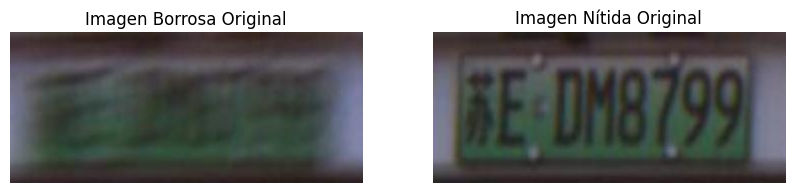

<ipython-input-4-fc1bb05e5c86>:7: UserWarning: Argument(s) 'always_apply' are not valid for transform BasicTransform
  'geometric': albu.OneOf([albu.HorizontalFlip(always_apply=True),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-4-fc1bb05e5c86>:8: UserWarning: Argument(s) 'always_apply' are not valid for transform ShiftScaleRotate
  albu.ShiftScaleRotate(always_apply=True),
<ipython-input-4-fc1bb05e5c86>:9: UserWarning: Argument(s) 'always_apply' are not valid for transform BasicTransform
  albu.Transpose(always_apply=True),
<ipython-input-4-fc1bb05e5c86>:10: UserWarning: Argument(s) 'always_apply' are not valid for transform OpticalDistortion
  albu.OpticalDistortion(always_apply=True),
<ipython-input-4-fc1bb05e5c86>:11: UserWarning: Argument(s) 'always_apply' are not valid for transform Elas

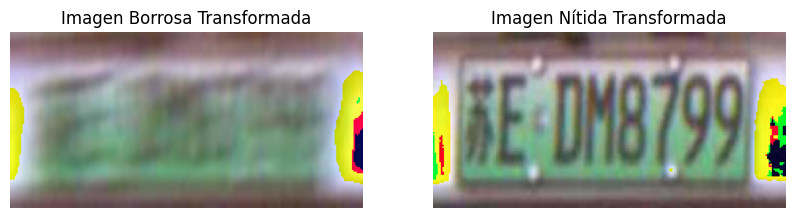

In [6]:
import cv2
import numpy as np
import albumentations as albu
from PIL import Image
import matplotlib.pyplot as plt

# Importar funciones de `aug.py`
#from data.aug import get_transforms, get_transforms_fortest, get_normalize

# Cargar imágenes de prueba (debes colocar la ruta correcta)
blur_path = "imgprueba/blur/grab9604.jpg"
sharp_path = "imgprueba/sharp/grab9604.jpg"

# Leer imágenes
blur_image = cv2.imread(blur_path)
sharp_image = cv2.imread(sharp_path)

# Convertir imágenes de BGR (cv2) a RGB (PIL y matplotlib trabajan con RGB)
blur_image = cv2.cvtColor(blur_image, cv2.COLOR_BGR2RGB)
sharp_image = cv2.cvtColor(sharp_image, cv2.COLOR_BGR2RGB)

# Mostrar imagen original
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(blur_image)
plt.title("Imagen Borrosa Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sharp_image)
plt.title("Imagen Nítida Original")
plt.axis("off")
plt.show()

# Definir el tamaño de la transformación
size = (112, 224)

# Obtener funciones de transformación
transform_fn = get_transforms(size)
normalize_fn = get_normalize()

# Aplicar transformaciones
blur_transformed, sharp_transformed = transform_fn(blur_image, sharp_image)
blur_transformed, sharp_transformed = normalize_fn(blur_transformed, sharp_transformed)

blur_transformed = (blur_transformed * 255).astype(np.uint8)
sharp_transformed = (sharp_transformed * 255).astype(np.uint8)


# Convertir de numpy a imagen de PIL para guardar
blur_pil = Image.fromarray(blur_transformed)
sharp_pil = Image.fromarray(sharp_transformed)

# Guardar imágenes transformadas
blur_pil.save("blur_transformada.jpg")
sharp_pil.save("sharp_transformada.jpg")

# Mostrar imágenes transformadas
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(blur_transformed)
plt.title("Imagen Borrosa Transformada")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sharp_transformed)
plt.title("Imagen Nítida Transformada")
plt.axis("off")
plt.show()


UTIL - DEEP


In [7]:
import torch
import numpy as np
import os
from util import util

# Crear un directorio para guardar imágenes
output_dir = "output_images"
util.mkdir(output_dir)

# Simular imágenes generadas por una red neuronal
num_images = 3
image_tensors = [torch.randn(1, 3, 256, 256) * 2 - 1 for _ in range(num_images)]  # Normalizadas [-1,1]
image_labels = ["image_1", "image_2", "image_3"]

# Procesar y guardar imágenes
for i, tensor in enumerate(image_tensors):
    image_numpy = util.tensor2im(tensor)  # Convertir tensor a imagen NumPy
    save_path = os.path.join(output_dir, f"{image_labels[i]}.png")
    util.save_image(image_numpy, save_path)  # Guardar imagen
    print(f"Imagen guardada en {save_path}")


Imagen guardada en output_images/image_1.png
Imagen guardada en output_images/image_2.png
Imagen guardada en output_images/image_3.png


In [9]:
!pip install dominate

In [20]:
from collections import OrderedDict
from util import html
from util.visualizer import Visualizer

# Configuración simulada de entrenamiento
class Opt:
    checkpoints_dir = "checkpoints"
    name = "experiment_1"
    display_winsize = 256
    display_ncols = 3
    mode = "train"
    no_html = False
    display_id = 1  # Habilita visdom si se usa

opt = Opt()

# Crear un objeto Visualizer
visualizer = Visualizer(opt)

# Crear un diccionario con imágenes y etiquetas
visuals = OrderedDict()
for i, tensor in enumerate(image_tensors):
    visuals[image_labels[i]] = tensor

# Simular el guardado de imágenes en una página HTML
epoch = 1
save_result = True
visualizer.display_current_results(visuals, epoch, save_result)

print("📄 Página HTML generada en: ", os.path.join(opt.checkpoints_dir, opt.name, "web/index.html"))


create web directory checkpoints/experiment_1/web...
📄 Página HTML generada en:  checkpoints/experiment_1/web/index.html
